## MLP 

We have considered adequated to treat this problem as natural language processing is normally treated. We have sequences of words that behave according to hidden grammar rules that the MLP has to learn in order the predict what word comes next. (Analogous to having a sequence of products that behave according to hidden market rules we need to learn in order to predict what product comes next). That is how we introduce the variable 'order' in the products.

Our training set can be made up of all the users, but we will 'hide' the last product they have purchased. That is 

- X_train = Sequence of products all users bought but the last one. 80%
- y_train = target we need to predict, that will be the last product they've purchased. 80%

- X_test = Sequence of all products but the last one 20%
- y_test = Last product this 20% have bought.

We will split the customers on train2.txt into this two groups, X_train, and X_test at random.

**Remarks:**

- We can add these 20% to the X_train (we shall give the sequence of the purchased products but the last two.) and add the second-to-last to the y_train.

- We can multiply the size training set by transforming the sequence of products 'abcde' to 'ab' 'abc' 'abcd' 'abcde'. 

- We MUST delete users with only one product, they have no training value. We can use to test but eh. I would just delete them.

- We are not using the Socio_Demo features, it would be better to treat them with another approach and then combine the two.

- We can delete worst selling products.

- We can train a model for every type of Socio_Demo_05


In [120]:
import numpy as np
import pandas as pd
from matplotlib import pyplot


In [121]:
#Load the data
dftrain = pd.read_csv('train2.txt', sep='|')
dftest= pd.read_csv('test2.txt', sep= '|')

In [122]:
dftrain.head(7)

,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05
0,A0000001,601,2007-05,5,4,3,1,0
1,A0000001,704,2013-04,5,4,3,1,0
2,A0000001,2501,2006-03,5,4,3,1,0
3,A0000001,2503,2006-03,5,4,3,1,0
4,A0000001,1011,2011-04,5,4,3,1,0
5,A0000002,601,1998-06,5,5,1,1,0
6,A0000002,801,2006-02,5,5,1,1,0


In [123]:
#Definea new column, we will fill it with the labels to identify every product. Those will be feed to the MLP.

dftrain['Prod_int'] = np.zeros(dftrain.ID_Customer.size, dtype=int)
print 'Entries: ' ,dftrain.shape
print 'Number of users: ' , dftrain.ID_Customer.unique().size

dftrain.head(6)

Entries:  (3350601, 9)
Number of users:  676370


,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Prod_int
0,A0000001,601,2007-05,5,4,3,1,0,0
1,A0000001,704,2013-04,5,4,3,1,0,0
2,A0000001,2501,2006-03,5,4,3,1,0,0
3,A0000001,2503,2006-03,5,4,3,1,0,0
4,A0000001,1011,2011-04,5,4,3,1,0,0
5,A0000002,601,1998-06,5,5,1,1,0,0


In [124]:
#Clean the dataframe from extremely rare products.

Sells_per_product = dftrain.groupby('Cod_Prod').ID_Customer.count()
Sells_per_product.describe()

count        94.000000
mean      35644.691489
std       96394.340067
min           1.000000
25%         364.250000
50%        3205.500000
75%       15433.500000
max      661756.000000
Name: ID_Customer, dtype: float64

In [125]:
products_sub100 = Sells_per_product[Sells_per_product <100].index.values
products_sub300 = Sells_per_product[Sells_per_product < 300].index.values
products_sub2500 = Sells_per_product[Sells_per_product <2500].index.values
print 'Products that we drop : ', products_sub100.shape, products_sub300.shape , products_sub2500.shape
a = Sells_per_product[Sells_per_product <100].sum()/float(Sells_per_product.sum())*100
b = Sells_per_product[Sells_per_product <300].sum()/float(Sells_per_product.sum())*100
c = Sells_per_product[Sells_per_product <2500].sum()/float(Sells_per_product.sum())*100
print 'Percentage of sells that we are droping: {0:.5f}%, {1:.5f}%, {2:.5f}%'.format(a, b, c)
products_sub100

Products that we drop :  (16,) (23,) (43,)
Percentage of sells that we are droping: 0.01128%, 0.05492%, 0.78246%


array([ 502,  504,  703,  803,  804, 1004, 1008, 1014, 1015, 1305, 1308,
       1312, 2104, 2502, 2801, 2901])

In any case we are just deleting below 1% of the total sales. If the train and the test are produced under the same cirumstances we do not expect that deleting low selling products affects our accuracy in more than a 1%.

In [126]:
#We delete rare products, the ones that have less than 100 sells

Filtereddf_100 = dftrain.query('Cod_Prod not in @products_sub100')

**IMPORTANT REMARK** : Deleting the products sub100 gives an accuracy of 47.39%. We have obtained better results without filtering which was 75%. We have yet not fully understood those results, and we have not reproduced again the first result of 75%. Since accuracy is not the main object of the first phase we have not explored this further.


We will continue with the raw data, since deleting products those not bring up accuracy.

In [127]:
Filtereddf = dftrain.copy()

In [128]:
products = Filtereddf.Cod_Prod.unique()
print 'unique products: ', products.size
products = np.sort(products)
products

unique products:  94


array([ 101,  102,  103,  104,  201,  301,  502,  503,  504,  506,  601,
        702,  703,  704,  705,  706,  707,  708,  801,  803,  804, 1001,
       1002, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
       1014, 1015, 1017, 1019, 1020, 1021, 1022, 1301, 1302, 1303, 1304,
       1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1401, 1501, 1801,
       1802, 1803, 1804, 1805, 1806, 2102, 2103, 2104, 2105, 2106, 2201,
       2202, 2203, 2204, 2205, 2206, 2301, 2302, 2401, 2501, 2502, 2503,
       2601, 2602, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2801, 2901,
       3001, 3101, 3401, 9991, 9992, 9993])

In [129]:
print 'Number of unique customers: ', Filtereddf.ID_Customer.unique().size

Number of unique customers:  676370


In [130]:
#Clean the dataframe of useless users.
dropusers = Filtereddf.groupby('ID_Customer')['Cod_Prod'].count()
dropusers = dropusers[dropusers == 1]
users_to_drop= dropusers.index
Filtereddf = Filtereddf.query('ID_Customer not in @users_to_drop')
print Filtereddf.shape
print Filtereddf.ID_Customer.unique().size
print (dftrain.ID_Customer.unique().size - Filtereddf.ID_Customer.unique().size)/float(dftrain.ID_Customer.unique().size)

(3277104, 9)
602873
0.108663896979


We have deleted roughly 75.000 users. A bit over 10%. That is still acceptable, so we are confident that our apporach can work.

In [131]:
#We Fill the column Prod_int. This will be the label the MLP will use to identify each product
#We save the label 0 for 'not bought anything'. This will become apparent when we construct the model

for i in range(products.size):
    Filtereddf.loc[Filtereddf['Cod_Prod'] == products[i], 'Prod_int']=i+1

In [132]:
Filtereddf.head()

,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Prod_int
0,A0000001,601,2007-05,5,4,3,1,0,11
1,A0000001,704,2013-04,5,4,3,1,0,14
2,A0000001,2501,2006-03,5,4,3,1,0,75
3,A0000001,2503,2006-03,5,4,3,1,0,77
4,A0000001,1011,2011-04,5,4,3,1,0,31


Todo OK.

In [133]:
#Divide the clients in training not training

Validusers= Filtereddf['ID_Customer'].unique()
users_for_test = np.random.choice(Validusers, size= int(len(Validusers)*0.2), replace= False)
data_test = Filtereddf.query('ID_Customer in @users_for_test')
data_train = Filtereddf.query('ID_Customer not in @users_for_test')
print 'Users for test: ', data_test.shape
print 'Users for train: ', data_train.shape

Users for test:  (655289, 9)
Users for train:  (2621815, 9)


In [134]:
historial_users_train=data_train.groupby(['ID_Customer', 'Prod_int'])['Cod_Fecha'].first()
historial_users_test= data_test.groupby(['ID_Customer', 'Prod_int'])['Cod_Fecha'].first()

In [135]:
historial_users_train.head()

ID_Customer  Prod_int
A0000001     11          2007-05
             14          2013-04
             31          2011-04
             75          2006-03
             77          2006-03
Name: Cod_Fecha, dtype: object

In [136]:
#Sort by fecha and convert indices to a sequences of list

historial_users_train.sort_values(inplace = True)
historial_users_test.sort_values(inplace = True)

In [137]:
X_train = historial_users_train.reset_index().groupby('ID_Customer')['Prod_int'].apply(np.array).values.tolist()
X_test = historial_users_test.reset_index().groupby('ID_Customer')['Prod_int'].apply(np.array).values.tolist()

In [138]:
X_train[:5]

[array([77, 75, 11, 31, 14]),
 array([ 6, 11, 19, 93]),
 array([11,  6,  5, 72]),
 array([ 6, 11]),
 array([ 6, 92, 94, 70, 11, 73])]

We have ended up with a list of sublists, the elements of the sublists are the products ordered by 'Fecha de compra'. Now we need to divide the data into input and output. 

In [139]:

#Dividimos entre X_train i y_train # SOLO EJECUTAR UNA VEZ BORRA COSAS
#Copy the last product to the target and then delete

X_traindel= np.copy(X_train)
X_testdel = np.copy(X_test)
y_train=np.zeros(len(X_train), dtype=int)
y_test=np.zeros(len(X_test), dtype=int)

i=0
for hist in X_train:
    y_train[i]=hist[-1:]
    X_traindel[i]= np.delete(X_train[i], X_train[i].size-1)
    i=i+1
i=0
for hist in X_test:
    y_test[i]=hist[-1:]
    X_testdel[i]= np.delete(X_test[i], X_test[i].size-1)
    i=i+1

In [140]:
Validusers= Filtereddf.ID_Customer.unique()
for i in np.random.choice(np.arange(len(X_train)), size=3):
    print 'Historial Usuario (en Train): ', i
    print X_train[i]
    print y_train[i]
    print X_traindel[i]
for i in np.random.choice(np.arange(len(X_test)), size=3):
    print 'Historial Usuario (en test): ', i
    print X_train[i]
    print y_train[i]
    print X_traindel[i]
  

Historial Usuario (en Train):  308737
[11 83  6  5 73 70 92 94 31]
31
[11 83  6  5 73 70 92 94]
Historial Usuario (en Train):  328720
[11 73  5 72]
72
[11 73  5]
Historial Usuario (en Train):  341218
[ 6 11 73  5 70 72]
72
[ 6 11 73  5 70]
Historial Usuario (en test):  112617
[11 70  6 65 78 80 93  5 31 73]
73
[11 70  6 65 78 80 93  5 31]
Historial Usuario (en test):  117119
[11 70  6 73 84 31]
31
[11 70  6 73 84]
Historial Usuario (en test):  10893
[11 93 86  6 31]
31
[11 93 86  6]


It seems like everything is in order. Labels for the train and the test are ok.

We shall now create the MLP model and fit it.

First we shall explore our training set. 

In [141]:
#Copy again into the original variables, we retain X_traindel so we can recover them at anytime
X_train=np.copy(X_traindel)
X_test=np.copy(X_testdel)
print 'Number of product sequences: ', len(X_train)
print 'Number of last objects:', y_train.size

Number of product sequences:  482299
Number of last objects: 482299


Mean lenght:  4.43607803458 Std:  3.00265729425


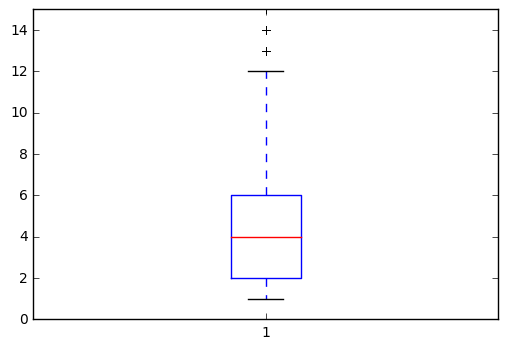

In [142]:
#Sumarize sequence lenght
size= map(len, X_train) #Applies function (len) to the sublists of X
print 'Mean lenght: ', np.mean(size), 'Std: ', np.std(size)
pyplot.boxplot(size)
pyplot.ylim(ymax=15)
pyplot.show()

The mean is 4.43 products with a std of 3 products, the median is 4 products. It is clear that we can get the full purchase historic for most users (75%) for sequences with a fixed lenght of 6.

Let's start building our model:

In [143]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
#Fix random seed to reproduce results
seed=7
np.random.seed(seed)

In [144]:
#Truncate or pad the sequences into maximum fixed lenght of 6
max_products=6
X_train = sequence.pad_sequences(X_train, maxlen=max_products)
X_test = sequence.pad_sequences(X_test, maxlen= max_products)

In [145]:
print X_train.shape
print X_test.shape
print X_train[0]

(482299, 6)
(120574, 6)
[ 0  0 77 75 11 31]


In [146]:
print 'Classes: '
print np.unique(y_test).shape
print np.unique(y_train).shape

Classes: 
(81,)
(89,)


There is one product more products in the train than the test. Since we have not deleted any product. Remember that there is some products with less than 10 sells! 

We are not pleased with this apporach, and we will work on improving accuracy in the second phase

In [147]:
print max_products

6


In [148]:
top_product=np.max(Filtereddf.Prod_int)
print 'Vocabulary Size: ', top_product
out_shape =Filtereddf.Cod_Prod.unique().size
print 'Output-shape: (number of products): ', out_shape

Vocabulary Size:  94
Output-shape: (number of products):  94


In [149]:
#Create the model:
vsdim = 10 #Dimension del espacio N-vectorial
model = Sequential()
model.add(Embedding(top_product+1 , vsdim, input_length=max_products))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(100, activation ='relu'))
model.add(Dense(top_product+1, activation='sigmoid')) #We need to add one since we encode the output with a one-hot encoder
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 6, 10)         950         embedding_input_2[0][0]          
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 60)            0           embedding_2[0][0]                
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 200)           12200       flatten_2[0][0]                  
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 200)           40200       dense_5[0][0]                    
___________________________________________________________________________________________

In [150]:
#Transform to categorical output
from keras.utils.np_utils import to_categorical

y_cat_train = to_categorical(y_train, nb_classes=None)
y_cat_test = to_categorical(y_test, nb_classes=None)
y_cat_train = y_cat_train.astype(int)
y_cat_test = y_cat_test.astype(int)
                                

In [151]:
print y_cat_train.shape
print X_train.shape

(482299, 95)
(482299, 6)


In [152]:
#Fit the model

model.fit(X_train, y_cat_train, validation_data=(X_test, y_cat_test), nb_epoch=3, batch_size=128, verbose=1)

scores=model.evaluate(X_test, y_cat_test, verbose=0)

print 'Accuracy: ', (scores[1]*100), '%'

Train on 482299 samples, validate on 120574 samples
Epoch 1/3
482299/482299 [==============================] - 26s - loss: 2.1168 - acc: 0.4035 - val_loss: 1.9266 - val_acc: 0.4611
Epoch 2/3
482299/482299 [==============================] - 26s - loss: 1.9096 - acc: 0.4647 - val_loss: 1.8920 - val_acc: 0.4685
Epoch 3/3
482299/482299 [==============================] - 25s - loss: 1.8810 - acc: 0.4703 - val_loss: 1.8722 - val_acc: 0.4719
Accuracy:  47.1925954186 %


Since the model overfits pretty quickly we have set for only 3 epochs.

In [153]:
#Prepare the test

dftest['Prod_int'] = np.zeros(dftest.ID_Customer.size, dtype=int)
print 'Entries: ' ,dftest.shape
print 'Number of users: ' , dftest.ID_Customer.unique().size
dftest.head()

Entries:  (1147687, 9)
Number of users:  258989


,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Prod_int
0,B0891376,601,1954-01,4,3,3,1,0,0
1,B0889436,601,1954-09,4,5,3,1,0,0
2,B0889461,601,1957-01,5,5,3,1,0,0
3,B0889491,601,1959-02,4,5,3,2,0,0
4,B0889492,601,1959-02,4,5,2,2,3,0


In [154]:
#We Fill the column Prod_int. This will be the label the MLP will use to identify each product
#We save the label 0 for 'not bought anything'. This will become apparent when we construct the model

for i in range(products.size):
    dftest.loc[dftest['Cod_Prod'] == products[i], 'Prod_int']=i+1

In [155]:
historial_users_predict=dftest.groupby(['ID_Customer', 'Prod_int'])['Cod_Fecha'].first()
historial_users_predict.head()

ID_Customer  Prod_int
B0676372     11          1978-01
B0676373     11          1993-07
B0676374     5           2006-01
             6           2002-11
             11          1995-08
Name: Cod_Fecha, dtype: object

In [156]:
X_predict = historial_users_predict.reset_index().groupby('ID_Customer')['Prod_int'].apply(np.array).values.tolist()

In [157]:
X_predict = sequence.pad_sequences(X_predict, maxlen=max_products)

In [158]:
predictions = model.predict(X_predict, verbose=1)
np.max(predictions[0])

258272/258989 [============================>.] - ETA: 0s

0.88682568

In [159]:
products.size

94

In [160]:
#We convert the nested list into a data frame, we drop the first column (0) corresponding to the ghost product 'not buying anything'

predictions_df = pd.DataFrame(predictions)
predictions_df.drop(0, axis=1, inplace= True)
predictions_df.columns = products
index =dftest.ID_Customer.unique()
index = np.sort(index)
predictions_df.index = index
predictions_df.head()

,101,102,103,104,201,301,502,503,504,506,...,2706,2707,2801,2901,3001,3101,3401,9991,9992,9993
B0676372,5.958446e-06,3.837236e-04,4.608266e-04,2.052419e-11,3.013037e-01,8.868257e-01,1.232875e-11,1.291795e-04,1.219546e-11,2.339920e-05,...,5.234530e-04,3.387867e-03,4.114937e-11,1.325356e-11,1.127517e-03,4.153980e-06,4.453513e-04,3.711745e-08,2.989615e-02,0.000004
B0676373,5.958446e-06,3.837236e-04,4.608266e-04,2.052419e-11,3.013037e-01,8.868257e-01,1.232875e-11,1.291795e-04,1.219546e-11,2.339920e-05,...,5.234530e-04,3.387867e-03,4.114937e-11,1.325356e-11,1.127517e-03,4.153980e-06,4.453513e-04,3.711745e-08,2.989615e-02,0.000004
B0676374,1.250661e-05,1.010403e-02,2.772507e-03,1.164733e-09,1.576573e-01,4.633081e-02,1.033373e-09,7.329836e-03,1.695177e-10,2.500749e-03,...,6.792096e-03,1.661954e-02,7.931691e-10,8.185848e-09,2.265819e-02,8.448527e-06,9.053930e-04,1.689642e-04,8.138381e-03,0.003417
B0676376,1.411914e-18,1.306403e-09,5.141419e-15,6.969722e-35,6.542153e-13,1.269048e-10,2.420917e-32,2.189442e-13,1.756354e-37,2.353298e-19,...,5.980805e-11,1.680744e-10,1.522930e-36,0.000000e+00,1.152020e-12,4.386683e-29,3.268188e-13,2.323360e-02,3.695012e-07,0.000188
B0676377,9.832833e-06,1.779501e-04,1.445912e-04,5.808259e-12,1.152420e-05,2.526369e-01,4.041044e-12,2.186667e-05,6.707437e-12,4.243167e-06,...,1.127333e-04,1.781676e-03,2.569655e-11,2.989999e-13,5.227211e-04,3.121106e-07,1.487970e-04,2.798310e-09,4.218665e-02,0.000091


In [161]:
#Find which column corresponds to the maximum for every user.

mission = predictions_df.idxmax(axis=1)
mission.indexname = 'ID_Customer'
mission.name = 'Cod_Prod'

In [162]:
mission.head(5)

B0676372     301
B0676373     301
B0676374    2301
B0676376    9991
B0676377    2302
Name: Cod_Prod, dtype: int64

In [163]:
mission.to_csv('Test_Mission.txt', sep='|', index_label='ID_Customer', header ='Cod_Prod')